https://www.programmerall.com/article/7073135248/


https://www.programmerall.com/article/25752039008/

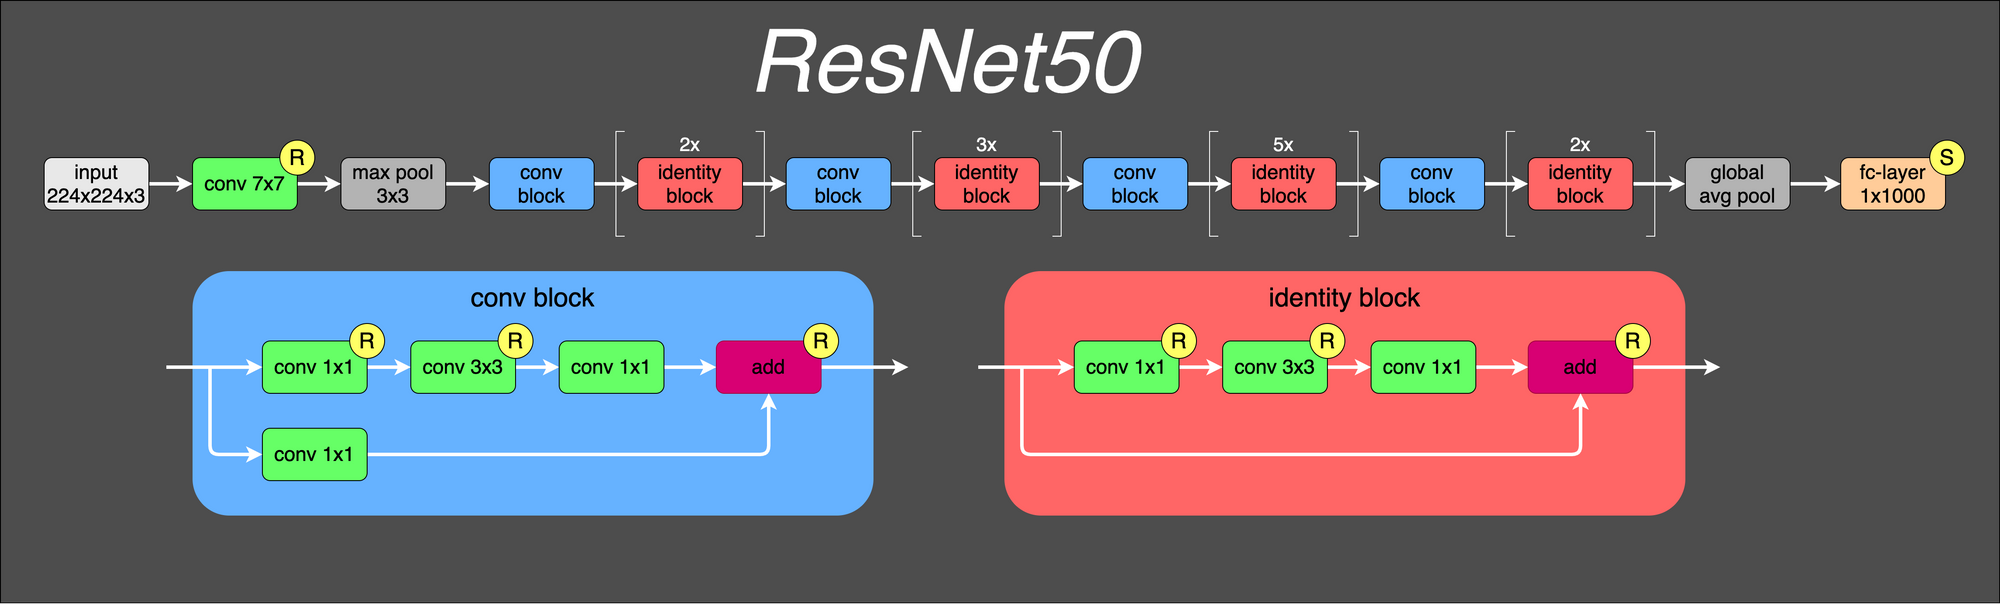

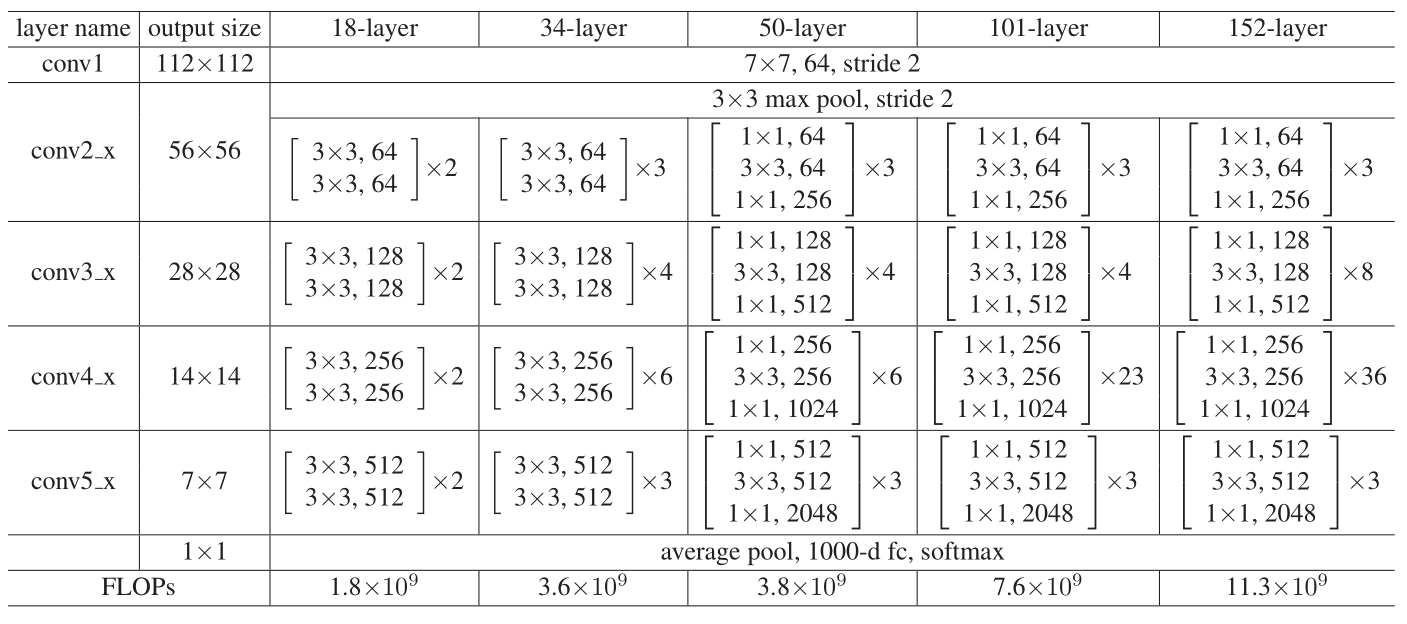

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device", device)

device cpu


In [22]:
batch_size,num_workers=2,1

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])

train_dataset = datasets.CIFAR10(root = 'data/', train = True, transform = trans, download=True)
test_dataset = datasets.CIFAR10(root='data/', train=False, transform=trans, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers = num_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers = num_workers)

100%|██████████| 170498071/170498071 [00:02<00:00, 65877359.57it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [34]:
class building_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(building_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, input):
        residual = input
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample:
            residual = self.downsample(input)
        x = x + residual
        output = self.relu(x)
        return output

In [35]:
class bottle_neck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsampling=False, expansion=4):
        super(bottle_neck, self).__init__()
        self.expansion = expansion
        self.downsampling = downsampling
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels*self.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels*self.expansion),
        )
        if self.downsampling:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels*self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*self.expansion)
            )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.bottleneck(x)

        if self.downsampling:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [38]:
def Conv1(in_channels, out_channels, stride = 2):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=7, stride=stride, padding=3, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    )

In [39]:
class ResNet(nn.Module):
    def __init__(self, blocks, num_classes, expansion = 4):
        super(ResNet, self).__init__()
        self.expansion = expansion
        self.conv1 = Conv1(in_channels=3, out_channels=64)
        self.layer1 = self.make_layer(in_channels=64, out_channels=64, block=blocks[0], stride=1)
        self.layer2 = self.make_layer(in_channels=256, out_channels=128, block=blocks[1], stride=2)
        self.layer3 = self.make_layer(in_channels=512, out_channels=256, block=blocks[2], stride=2)
        self.layer4 = self.make_layer(in_channels=1024, out_channels=512, block=blocks[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(2048,num_classes)

    def make_layer(self, in_channels, out_channels, block, stride):
        layers = []
        layers.append(bottle_neck(in_channels, out_channels, stride, downsampling=True))
        for i in range(1, block):
            layers.append(bottle_neck(out_channels*self.expansion, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def ResNet50():
    return ResNet([3, 4, 6, 3], num_classes = 10)

def ResNet101():
    return ResNet([3, 4, 23, 3], num_classes = 10)

def ResNet152():
    return ResNet([3, 8, 36, 3], num_classes = 10)

In [40]:
#model = torchvision.models.resnet50()
model = ResNet101()
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): bottle_neck(
      (bottleneck): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      

In [41]:
input = torch.randn(1, 3, 224, 224)
out = model(input)
print(out.shape)

torch.Size([1, 10])


In [46]:
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=0.001)

In [47]:
import time

def test():
    start = time.time()
    acc_sum = 0
    batch = 0
    for X,y in train_loader:
        y_hat = model(X)
        acc_sum += (y_hat.argmax(dim=1) == y).float().sum().item()
        batch += 1
    #print('acc_sum %d,batch %d' % (acc_sum,batch))

    acc = 1.0*acc_sum/(batch*batch_size)
    end = time.time()
    # print('acc %3f,test for test dataset:time %d' % (acc,end - start))

    return acc

In [55]:
num_epochs = 3
save_to_disk = False

def train():
    counter = 0
    for epoch in range(num_epochs):
        train_l_sum, batch, acc_sum = 0,0,0
        start = time.time()

        for X,y in train_loader:
            start_batch_begin = time.time()
            # X,y = X.cuda(),y.cuda()
            y_hat = model(X)
            acc_sum += (y_hat.argmax(dim=1) == y).float().sum().item()

            l = loss(y_hat,y)
            opt.zero_grad()
            l.backward()

            opt.step()
            train_l_sum += l.item()

            batch += 1

            mean_loss = train_l_sum/(batch*batch_size) #Calculate the average loss to each picture
            start_batch_end = time.time()
            time_batch = start_batch_end - start

            train_acc = acc_sum/(batch*batch_size)
            print("working... ", counter)
            if batch % 100 == 0:
                print('f epoch %d,batch %d,train_loss %.3f,train_acc:%.3f,time %.3f' %
                    (epoch,batch,mean_loss,train_acc,time_batch))
                print('***************************************')

            # if save_to_disk and batch % 1000 == 0:
            #     model_state = net.state_dict()
            #     model_name = 'nin_epoch_%d_batch_%d_acc_%.2f.pt' % (epoch,batch,train_acc)
            #     torch.save(model_state,model_name)

        mean_loss = train_l_sum/(batch*batch_size) #Calculate the average loss to each picture
        train_acc = acc_sum/(batch*batch_size) #Calculate training accuracy
        test_acc = test() #Calculate test accuracy

        counter += 1
        if counter > 1000 : break

        end = time.time()
        time_per_epoch =  end - start
        print('epoch %d,train_loss %f,train_acc %f,test_acc %f,time %f' %
                (epoch + 1,mean_loss,train_acc,test_acc,time_per_epoch))

In [56]:
train()

working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
working...  0
workin

KeyboardInterrupt: 